In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
'''
all helper functions
'''
# i) matrix transpose
def transpose(A):
    return [[row[i] for row in A] for i in range(len(A[0]))]

# ii) matrix inverse
# Gauss elimination
def eliminate(row1, row2, col, aim):
    fac = (row2[col]-aim) / row1[col]
    for i in range(len(row2)):
        row2[i] -= fac * row1[i]
def gauss(A):
    for i in range(len(A)):
        if A[i][i] == 0:
            for j in range(i+1, len(A)):
                if A[i][j] != 0:
                    A[i], A[j] = A[j], A[i]
                    break
            else:
                raise ValueError("Matrix is not invertible")
        for j in range(i+1, len(A)):
            eliminate(A[i], A[j], i, 0)
    for i in range(len(A)-1, -1, -1):
        for j in range(i-1, -1, -1):
            eliminate(A[i], A[j], i, 0)
    for i in range(len(A)):
        eliminate(A[i], A[i], i, 1)
    return A
def inverse(A):
    tmp = [[] for _ in A]
    for i,row in enumerate(A):
        tmp[i].extend(row + [0]*i + [1] + [0]*(len(A)-i-1))
    gauss(tmp)
    res = []
    for i in range(len(tmp)):
        res.append(tmp[i][len(tmp[i])//2:])
    return res

# iii) matrix determinant
# create minors
def minor(A, i, j):
    Am = []
    for ii in range(len(A)):
        if ii!=i:
            res = []
            for jj in range(len(A[0])):
                if jj!=j:
                    res.append(A[i][j])
            Am.append(res)
    return Am    
def det(A):
    n = len(A)
    if n == 1 :return A[0][0]
    if n == 2 :return A[0][0]*A[1][1] - A[0][1]*A[1][0]
    temp = 0
    for i in range(0,n):
        m = minor(A,0,i)
        temp =temp + ((-1)**i)*A[0][i] * det(m)
    return temp

# iv) cholesky decomposition
def cholesky(A):
    A = np.array(A)
    L = np.zeros_like(A)
    for row in range(len(A)):
        for col in range(row+1):
            tmp_sum = L[row,:col]@L[col,:col]
            if (row == col): # Diagonal elements
                L[row, col] = (max(A[row,row] - tmp_sum, 0))**0.5
            else:
                L[row,col] = (1.0 / L[col,col]) * (A[row,col] - tmp_sum)
    return L

# part a) 
def maha_dist(x, mu, Sigma, d):
    if len(x) == len(mu) == len(Sigma) == len(Sigma[0]):
        return (transpose(x-mu) @ np.array(inverse(Sigma)) @ (x-mu)) [0, 0]
    else:
        return "dimension error!"

# part b)
def discriminant(x, mu, Sigma, d, prior):
    return -1/2*maha_dist(x, mu, Sigma, d)-d/2*np.log(2*np.pi)-1/2*np.log(det(Sigma))+np.log(prior)

# part c)
def gen_sample(mu, Sigma, d):
    x = np.random.normal(size=(d, 1))
    return cholesky(Sigma1) @ x + mu

def gen_sample_n(mu, Sigma, d, n_sim=1000):
    data = np.zeros((2, n_sim))
    for i in range(n_sim):
        data[:, i] = gen_sample(mu, Sigma, d).reshape(2)
    return data

def multi_normal_pdf(x, mu, Sigma, d, prior):
    return np.exp(discriminant(x, mu, Sigma, d, prior)-np.log(prior))


In [3]:
# part d) 3d plots for two classes
def plot_3d(mu1, Sigma1, mu2, Sigma2, d, prior1, prior2, data1, data2, n_mesh=100):
    x = np.linspace(-5,12,n_mesh)
    y = np.linspace(-5,12,n_mesh)
    X, Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y

    pdfs1 = np.zeros((n_mesh, n_mesh))
    for i in range(n_mesh):
        for j in range(n_mesh):
            pdfs1[i, j] = multi_normal_pdf(pos[i, j].reshape((2, 1)), mu1, Sigma1, d, prior1)

    pdfs2 = np.zeros((n_mesh, n_mesh))
    for i in range(n_mesh):
        for j in range(n_mesh):
            pdfs2[i, j] = multi_normal_pdf(pos[i, j].reshape((2, 1)), mu2, Sigma2, d, prior2)

    def boundary(x1):
        for x2 in y:
            x = np.array([[x1], [x2]])
            if discriminant(x, mu1, Sigma1, d, prior1) < discriminant(x, mu2, Sigma2, d, prior2):
                return x2
        return np.nan
    bound = [boundary(xx) for xx in np.linspace(-4,9,n_mesh)]

    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, pdfs1,cmap='Reds',linewidth=0, alpha=0.2)
    ax.plot_surface(X, Y, pdfs2,cmap='Blues',linewidth=0)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('density')

    ax.scatter(data1[0], data1[1], np.ones(len(data1[0]))*-(max(np.max(pdfs2), np.max(pdfs1))), color='red',
              label='random sample from class 1')
    ax.scatter(data2[0], data2[1], np.ones(len(data2[0]))*-(max(np.max(pdfs2), np.max(pdfs1))), color='blue',
              label='random sample from class 1')
    ax.plot(np.linspace(-4,9,n_mesh), bound, np.ones(n_mesh)*-(max(np.max(pdfs2), np.max(pdfs1))),
           label='decision boundary')
    ax.legend()
    plt.tight_layout()
    
# part e) posterior probabilities
def plot_posterior(mu1, Sigma1, mu2, Sigma2, d, prior1, prior2, data1, data2, n_mesh=100):
    x = np.linspace(-5,12,n_mesh)
    y = np.linspace(-5,12,n_mesh)
    X, Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y

    pdfs1 = np.zeros((n_mesh, n_mesh))
    for i in range(n_mesh):
        for j in range(n_mesh):
            pdfs1[i, j] = multi_normal_pdf(pos[i, j].reshape((2, 1)), mu1, Sigma1, d, prior1)

    pdfs2 = np.zeros((n_mesh, n_mesh))
    for i in range(n_mesh):
        for j in range(n_mesh):
            pdfs2[i, j] = multi_normal_pdf(pos[i, j].reshape((2, 1)), mu2, Sigma2, d, prior2)
    
    post1 = np.zeros((n_mesh, n_mesh))
    for i in range(n_mesh):
        for j in range(n_mesh):
            post1[i, j] = prior1*pdfs1[i, j]/(prior1*pdfs1[i, j]+prior2*pdfs2[i, j])
    
    post1_data1 = np.zeros(len(data1[0]))
    for i in range(len(data1[0])):
        pdf1 = multi_normal_pdf(data1[:, i].reshape((2, 1)), mu1, Sigma1, d, prior1)
        pdf2 = multi_normal_pdf(data1[:, i].reshape((2, 1)), mu2, Sigma2, d, prior2)
        post1_data1[i] = prior1*pdf1/(prior1*pdf1+prior2*pdf2)

    post1_data2 = np.zeros(len(data2[0]))
    for i in range(len(data2[0])):
        pdf1 = multi_normal_pdf(data2[:, i].reshape((2, 1)), mu1, Sigma1, d, prior1)
        pdf2 = multi_normal_pdf(data2[:, i].reshape((2, 1)), mu2, Sigma2, d, prior2)
        post1_data2[i] = prior1*pdf1/(prior1*pdf1+prior2*pdf2)

    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, post1,cmap='Greens',linewidth=0, alpha=0.2)
    ax.scatter(data1[0], data1[1], post1_data1, color='red',
              label='posterior probabilities of belonging to class 1 for random sample from class 1')
    ax.scatter(data2[0], data2[1], post1_data2, color='blue',
              label='posterior probabilities of belonging to class 1 for random sample from class 2')    
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('posterior')
    ax.legend()
    plt.tight_layout()

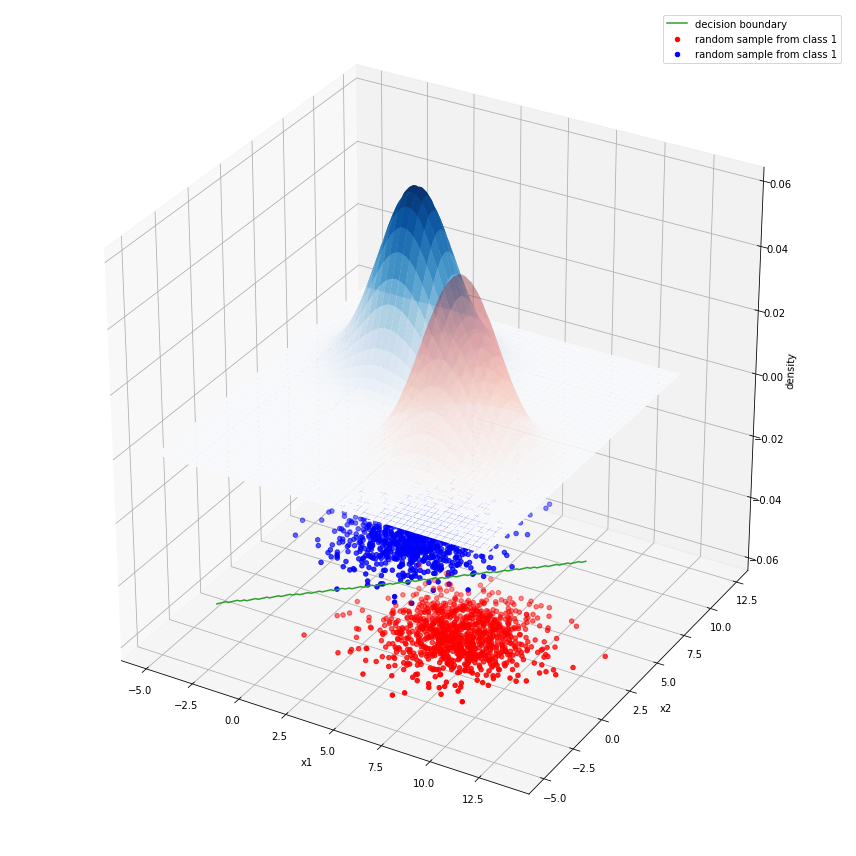

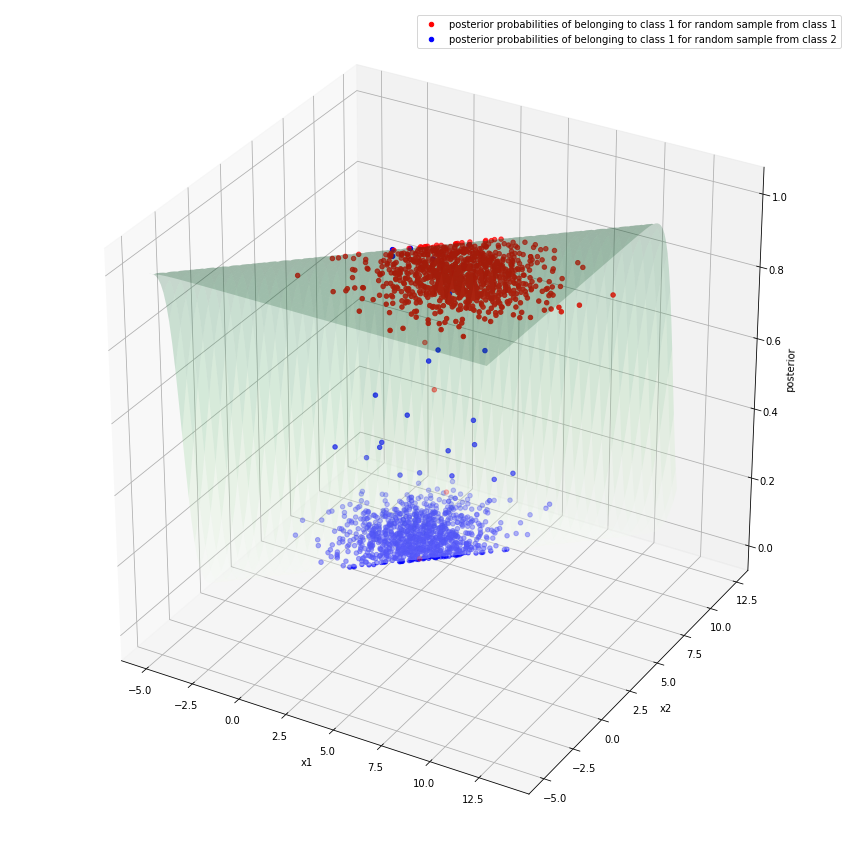

In [4]:
x   = np.array([[1], [1]])
mu1 = np.array([[7], [1]])
mu2 = np.array([[1], [7]])
Sigma1 = [[3.1, 0], 
                   [0, 2.6]]
Sigma2 = [[3.1, 0], 
                   [0, 2.6]]
prior1, prior2 = 0.8, 0.2
d = 2

data1 = gen_sample_n(mu1, Sigma1, d)
data2 = gen_sample_n(mu2, Sigma2, d)

plot_3d(mu1, Sigma1, mu2, Sigma2, d, prior1, prior2, data1, data2)
plt.savefig('d1.jpg', dpi=150)
plot_posterior(mu1, Sigma1, mu2, Sigma2, d, prior1, prior2, data1, data2)
plt.savefig('d2.jpg', dpi=150)

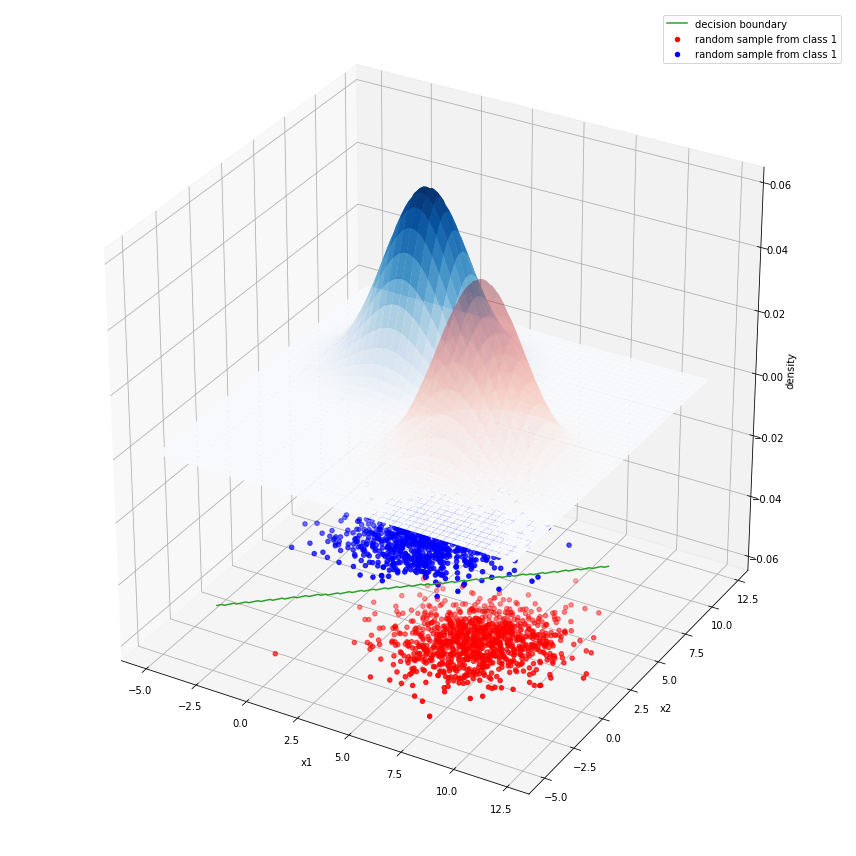

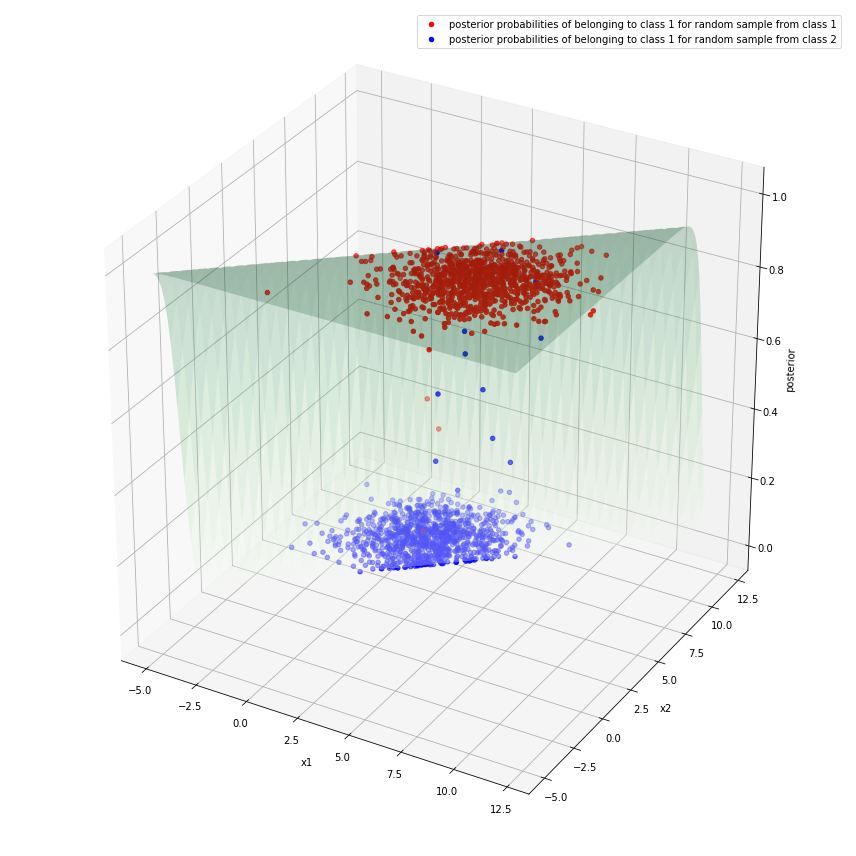

In [5]:
x   = np.array([[1], [1]])
mu1 = np.array([[7], [1]])
mu2 = np.array([[1], [7]])
Sigma1 = [[3.1, 0.35], 
                   [0.35, 2.6]]
Sigma2 = [[3.1, 0.35], 
                   [0.35, 2.6]]
prior1, prior2 = 0.8, 0.2
d = 2

data1 = gen_sample_n(mu1, Sigma1, d)
data2 = gen_sample_n(mu2, Sigma2, d)

plot_3d(mu1, Sigma1, mu2, Sigma2, d, prior1, prior2, data1, data2)
plt.savefig('e1.jpg', dpi=150)
plot_posterior(mu1, Sigma1, mu2, Sigma2, d, prior1, prior2, data1, data2)
plt.savefig('e2.jpg', dpi=150)

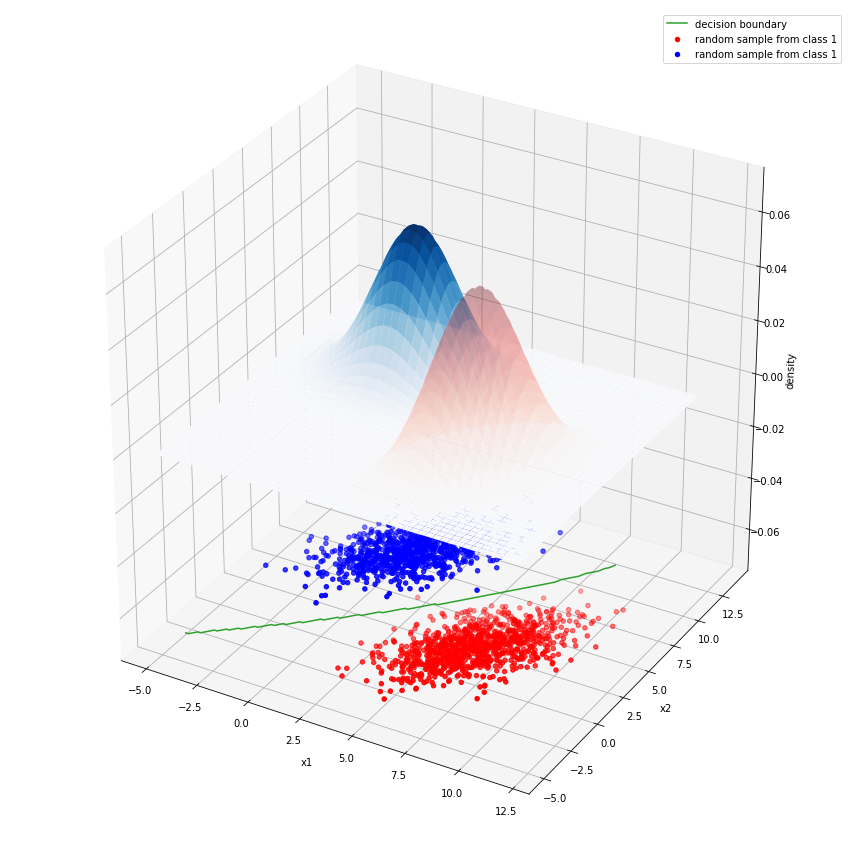

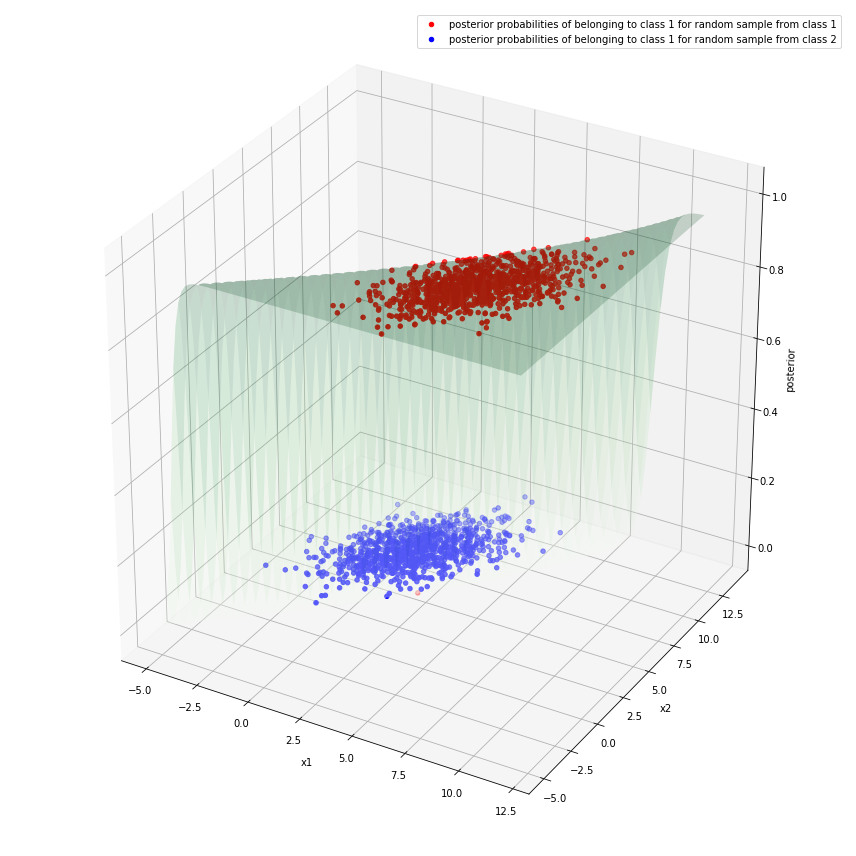

In [6]:
x   = np.array([[1], [1]])
mu1 = np.array([[7], [1]])
mu2 = np.array([[1], [7]])
Sigma1 = [[2.1, 1.5], 
                   [1.5, 3.8]]
Sigma2 = [[3.1, 0.35], 
                   [0.35, 2.6]]
prior1, prior2 = 2/3, 1/3
d = 2

data1 = gen_sample_n(mu1, Sigma1, d)
data2 = gen_sample_n(mu2, Sigma2, d)

plot_3d(mu1, Sigma1, mu2, Sigma2, d, prior1, prior2, data1, data2)
plt.savefig('f1.jpg', dpi=150)
plot_posterior(mu1, Sigma1, mu2, Sigma2, d, prior1, prior2, data1, data2)
plt.savefig('f2.jpg', dpi=150)